# MNIST with a basic FC network

## Prepare training/validation data

In [1]:
from torchvision.datasets import MNIST

In [2]:
mnist_train = MNIST('./', train=True, download=True)

In [3]:
all_train_labels = mnist_train.targets.numpy()
all_train_data = mnist_train.data.numpy()

In [4]:
print('Data shape: ', all_train_data.shape)
print('Labels shape: ', all_train_labels.shape)

Data shape:  (60000, 28, 28)
Labels shape:  (60000,)


In [5]:
n_train = int(all_train_labels.size * 0.9)
print('Samples for training: ', n_train)
print('Samples for validation: ', all_train_labels.size - n_train)

Samples for training:  54000
Samples for validation:  6000


In [6]:
train_data = all_train_data[:n_train]
train_labels = all_train_labels[:n_train]
val_data = all_train_data[n_train:]
val_labels = all_train_labels[n_train:]

In [7]:
assert train_data.shape[0] == train_labels.shape[0] and val_data.shape[0] == val_labels.shape[0]

In [8]:
import matplotlib.pyplot as plt

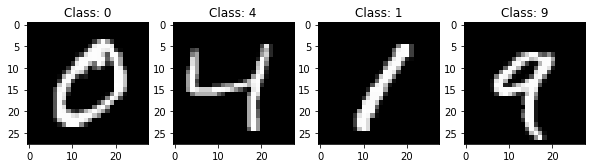

In [9]:
plt.figure(figsize=(10, 10))
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.imshow(train_data[i], cmap='gray')
    plt.title(f'Class: {train_labels[i]}')
plt.show()

## Batching

In [11]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

In [12]:
from simple_learning.utils import DataLoader

In [13]:
batch_size = 5000
train_loader = DataLoader(train_data, train_labels, batch_size)

## Imports

In [14]:
from tqdm import tqdm

import simple_learning as sl
import simple_learning.nn as nn
import simple_learning.functional as F
from simple_learning.optim import SGD
from simple_learning.utils import TrainLogger

## Model

In [15]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear (100, output_size)
    
    def forward(self, x):
        x = sl.tensor.to_tensor(x)
        x = x.reshape((-1, self.input_size))
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        x = F.relu(x)
        
        return F.softmax(x)

## Training

In [20]:
epochs = 50
learning_rate = 0.01
momentum = 0.9

loss_fn = F.cross_entropy
logger = TrainLogger()

In [21]:
examples, width, height = train_data.shape
num_classes = len(mnist_train.classes)

In [22]:
model = SimpleModel((width*height), num_classes)
optimizer = SGD(model.get_parameters(), learning_rate, momentum)

In [23]:
val_every = 5

In [24]:
for i in tqdm(range(epochs), desc='Training model'):
    for j, (data, targets) in enumerate(train_loader):
        logits = model(data/255)
        
        loss = loss_fn(logits, targets)
        logger.log_loss(loss.item(), 'train')
        loss.backward()
        
        logger.log_metrics(logits, targets, 'train', 'accuracy')
        
        optimizer.step()
        optimizer.zero_grad()
    
    if i % val_every == 0:
        with sl.no_grad():
            logits = model(val_data/255)
            
            loss = loss_fn(logits, val_labels)
            logger.log_loss(loss.item(), 'val')
            
            logger.log_metrics(logits, val_labels, 'val', 'accuracy')

Training model: 100%|██████████| 50/50 [08:15<00:00,  9.91s/it]


## Visualizing performance

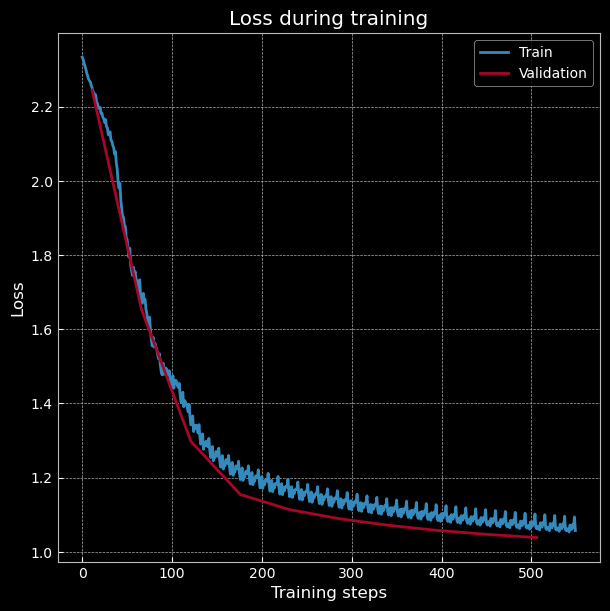

In [25]:
logger.plot_loss()

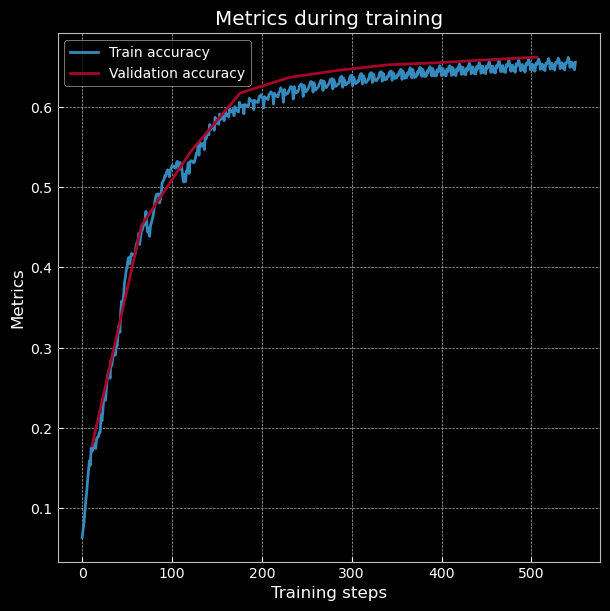

In [26]:
logger.plot_metrics()

## Final Metrics

In [35]:
print('Final train accuracy:', logger.train_metric_log['accuracy'][-1][1])

Final train accuracy: 0.6555


In [36]:
print('Final validation accuracy:', logger.val_metric_log['accuracy'][-1][1])

Final validation accuracy: 0.662
